# Lab 4: Testing Notebook

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg
from psycopg.rows import dict_row

## Part 1: Data Importing

In [9]:
import pandas as pd
import psycopg

# Connection details
user = "postgres"
password = "psql-password"
host = "127.0.0.1"
conn_string = f"postgresql://{user}:{password}@{host}:5432/house_price_prediction_service"

with psycopg.connect(conn_string, row_factory=psycopg.rows.dict_row) as conn:
    with conn.cursor(name="fetch_all_cursor") as cur:  # Use server-side cursor
        cur.execute("""
            SELECT 
                id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot,
                floors, waterfront, view, condition, grade, sqft_above, sqft_basement,
                yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15,
                population, high_schools, middle_schools, primary_schools, other_schools,
                unknown_schools, total_schools
            FROM cleaned_home_sale_events;
        """)
        
        rows = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(rows)

# Show how many rows were fetched
print(f"Total rows fetched: {len(df)}")

# Display the dataframe
df.head()

Total rows fetched: 130668


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,population,high_schools,middle_schools,primary_schools,other_schools,unknown_schools,total_schools
0,86427,2025-02-25,507000.0,4,2.5,2730,7649,2.0,0,0,...,-121.882,2730,None,38097,2,1,2,2,0,7
1,86528,2025-02-25,408200.0,3,2.5,1800,5761,2.0,0,0,...,-122.363,1800,None,68619,1,0,3,0,0,4
2,86253,2025-02-25,290000.0,4,1.0,1330,8184,1.5,0,0,...,-122.347,1220,None,133665,3,0,6,0,0,9
3,86426,2025-02-25,320000.0,3,2.5,2680,7757,2.0,0,0,...,-122.346,2430,None,142530,2,2,11,0,0,15
4,86512,2025-02-25,450000.0,2,2.0,1100,3000,1.5,0,0,...,-122.362,1390,None,94095,1,1,5,1,0,8


## Part 2: Creating a Regression Model

Model: Linear Regression
  RMSE: $124352.18
  MAPE: 13.22%
  R-squared: 0.8870


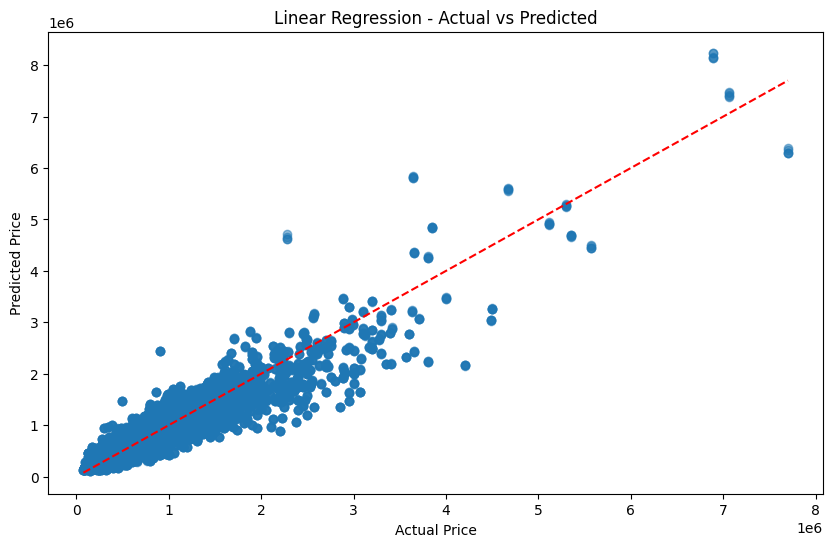

Model: Ridge Regression
  RMSE: $124344.56
  MAPE: 13.23%
  R-squared: 0.8869


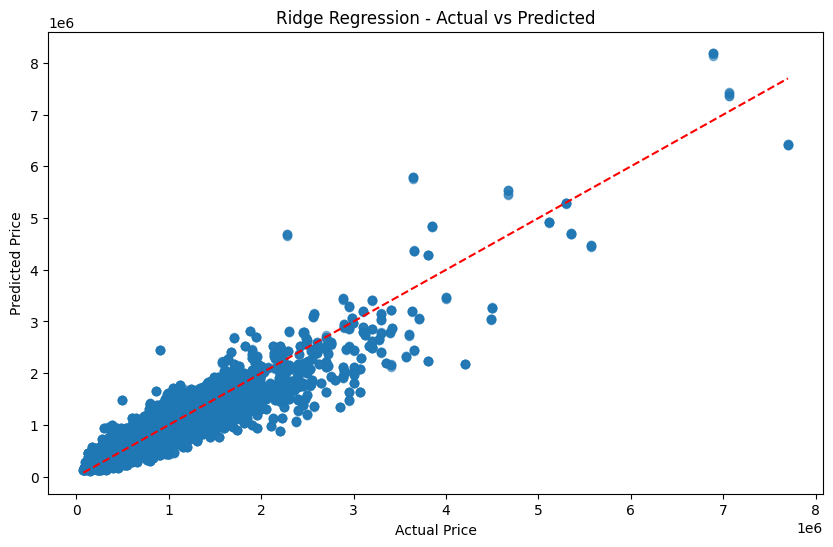

Model: Lasso Regression
  RMSE: $249189.18
  MAPE: 25.13%
  R-squared: 0.6356


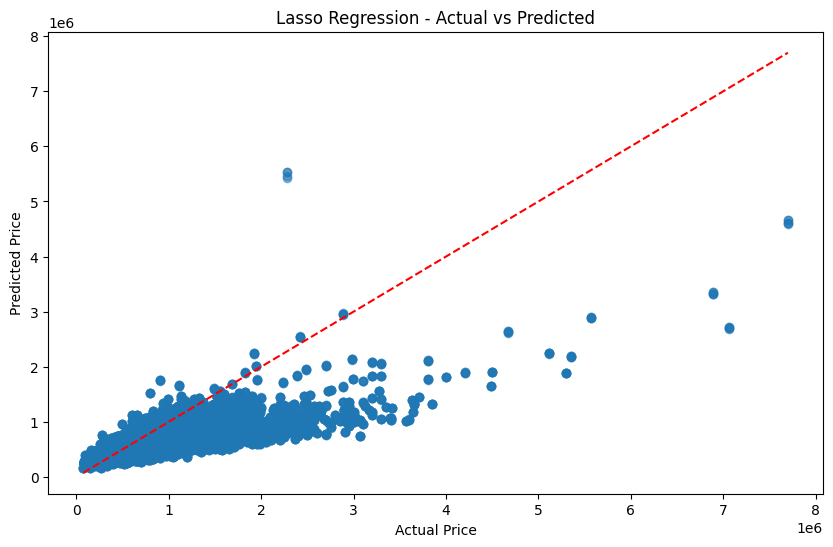

Model: ElasticNet
  RMSE: $220501.03
  MAPE: 21.85%
  R-squared: 0.7201


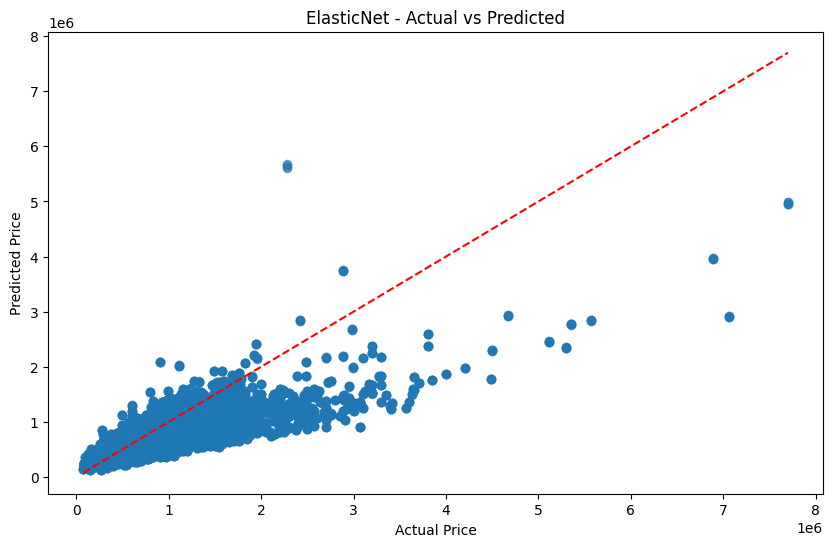

Model: Random Forest
  RMSE: $17214.92
  MAPE: 1.44%
  R-squared: 0.9965


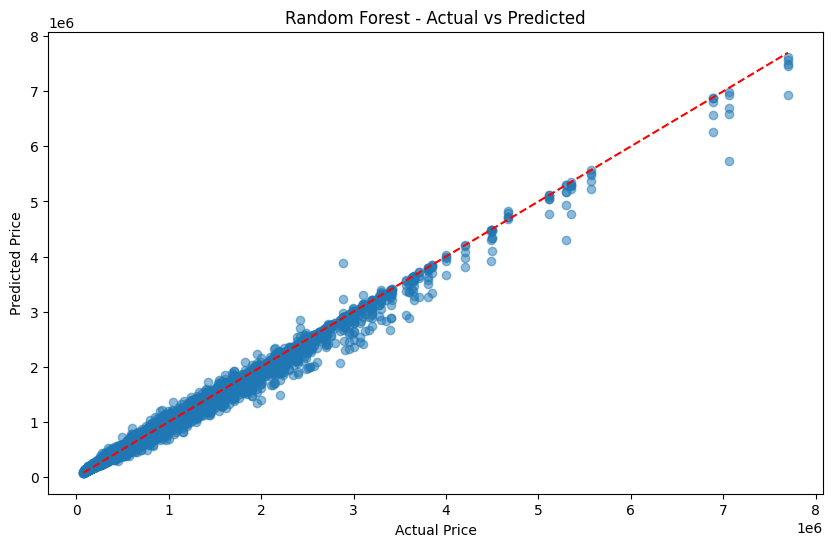

Model: Gradient Boosting
  RMSE: $122814.95
  MAPE: 12.86%
  R-squared: 0.8929


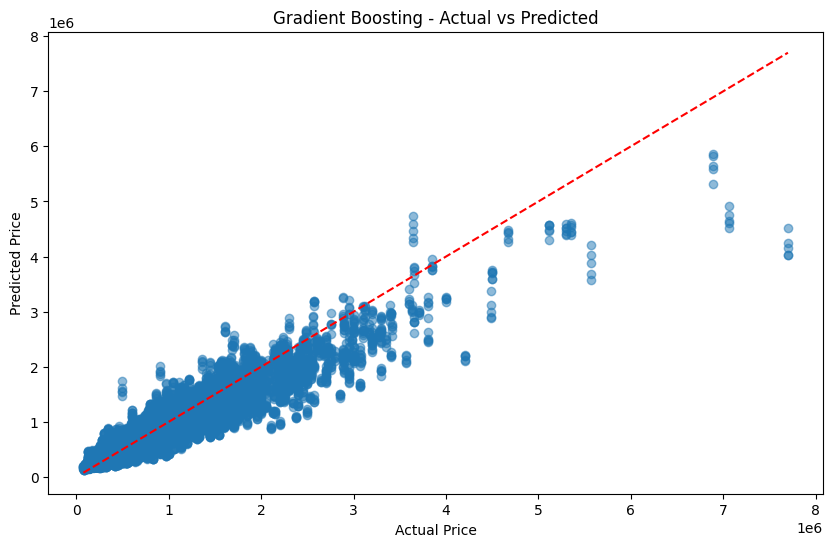

Model: XGBoost
  RMSE: $66960.58
  MAPE: 8.50%
  R-squared: 0.9536


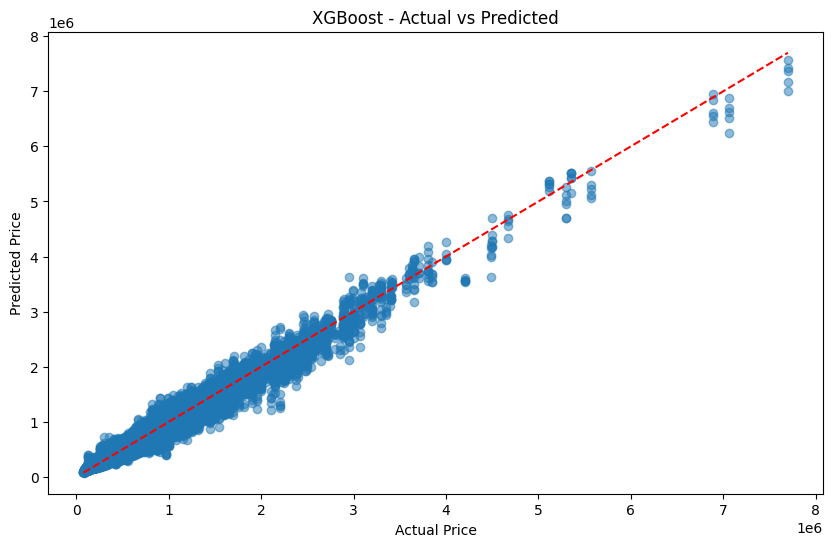


Model Comparison:
                name           rmse       mape        r2
4      Random Forest   17214.916933   1.435565  0.996535
6            XGBoost   66960.581534   8.501280  0.953597
5  Gradient Boosting  122814.954626  12.861993  0.892868
1   Ridge Regression  124344.563780  13.228935  0.886949
0  Linear Regression  124352.182266  13.223788  0.887005
3         ElasticNet  220501.030096  21.854874  0.720134
2   Lasso Regression  249189.180593  25.130322  0.635645


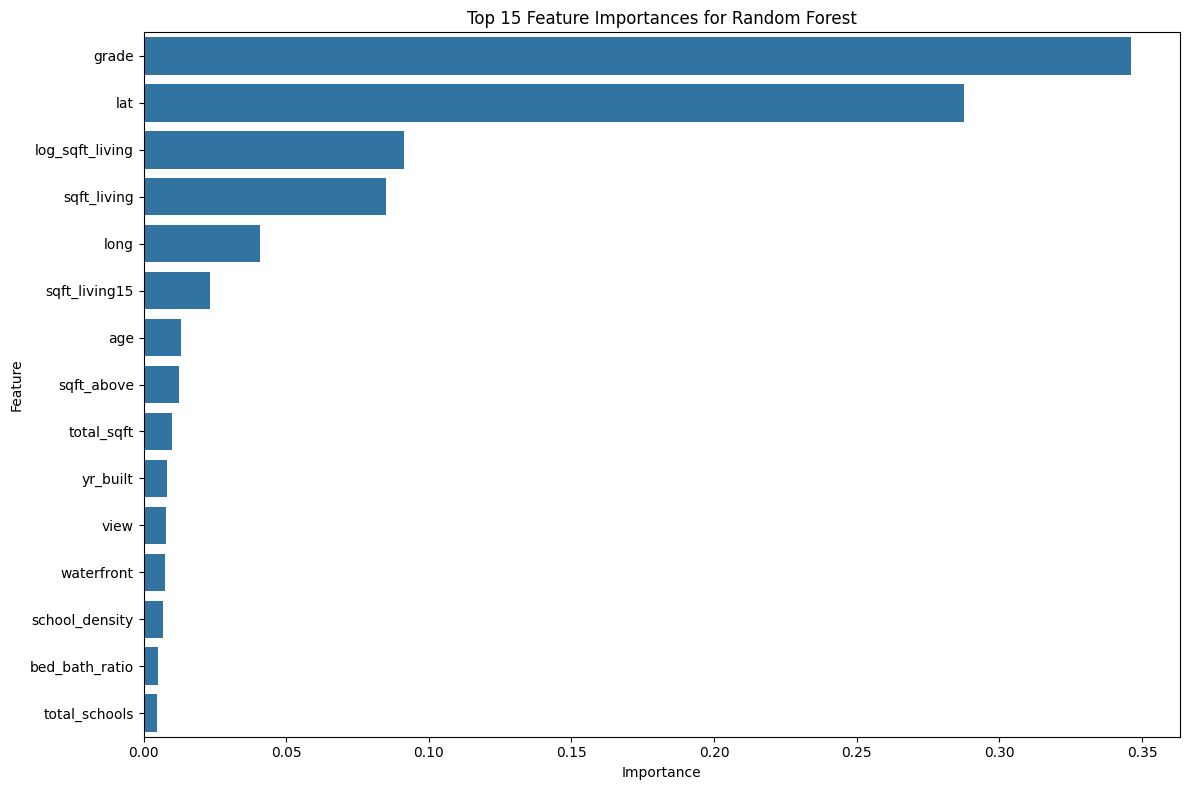


Hyperparameter tuning for Random Forest
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best RMSE: $889.52
Model: Tuned Random Forest
  RMSE: $16711.64
  MAPE: 1.41%
  R-squared: 0.9966


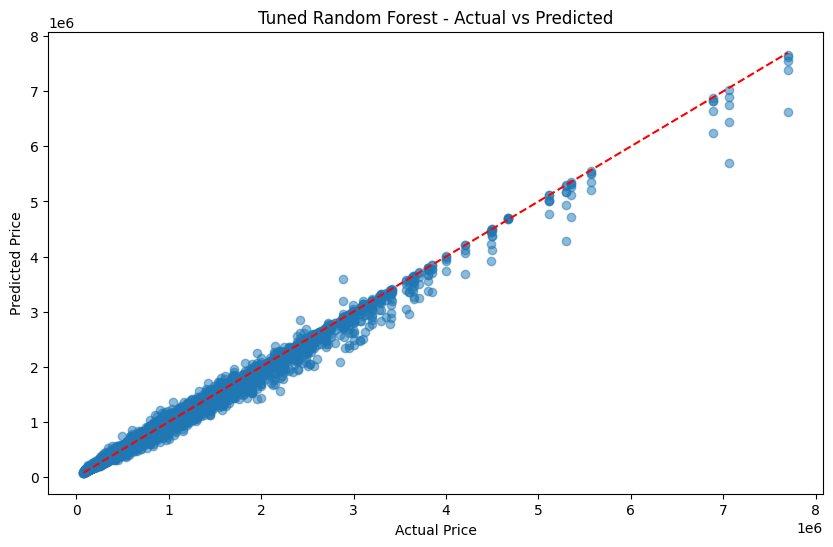


Updated Model Comparison:
                  name           rmse       mape        r2
7  Tuned Random Forest   16711.640677   1.411618  0.996643
4        Random Forest   17214.916933   1.435565  0.996535
6              XGBoost   66960.581534   8.501280  0.953597
5    Gradient Boosting  122814.954626  12.861993  0.892868
1     Ridge Regression  124344.563780  13.228935  0.886949
0    Linear Regression  124352.182266  13.223788  0.887005
3           ElasticNet  220501.030096  21.854874  0.720134
2     Lasso Regression  249189.180593  25.130322  0.635645

Final Selected Model: Tuned Random Forest
RMSE: $16711.64
MAPE: 1.41%
R-squared: 0.9966

Conclusion:
The best model for house price prediction is Tuned Random Forest.
This model achieves an RMSE of $16711.64, 
a MAPE of 1.41%, 
and an R-squared of 0.9966.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preparation
# Convert date to datetime and extract features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear

# Sort by date to ensure proper time series split
df = df.sort_values('date')

# Handle missing values in sqft_lot15
df['sqft_lot15'] = df['sqft_lot15'].fillna(df['sqft_lot'])

# 2. Feature Engineering
# Create new features
df['age'] = df['year'] - df['yr_built']
df['renovated'] = (df['yr_renovated'] > 0).astype(int)
df['total_sqft'] = df['sqft_living'] + df['sqft_lot']

# Avoid division by zero
df['price_per_sqft'] = np.where(df['sqft_living'] > 0, df['price'] / df['sqft_living'], 0)
df['bed_bath_ratio'] = np.where(df['bathrooms'] > 0, df['bedrooms'] / df['bathrooms'], 0)
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['school_density'] = np.where(df['population'] > 0, df['total_schools'] / df['population'] * 10000, 0)

# Log transform price and some features to normalize distributions - add small constant to avoid log(0)
df['log_price'] = np.log1p(df['price'])
df['log_sqft_living'] = np.log1p(df['sqft_living'])
df['log_sqft_lot'] = np.log1p(df['sqft_lot'])
df['log_population'] = np.log1p(df['population'])

# Create categorical features as needed
df['age_category'] = pd.cut(df['age'], bins=[0, 10, 20, 40, 80, 150], labels=['New', 'Recent', 'Mid', 'Old', 'Very Old'])
df['size_category'] = pd.cut(df['sqft_living'], bins=[0, 1000, 2000, 3000, 5000, 15000], labels=['Tiny', 'Small', 'Medium', 'Large', 'Mansion'])

# 3. Define features and target
# We'll use log_price as our target for better model performance
target = 'log_price'
y = df[target]

# Select features, removing direct price-related columns and the original target
non_features = ['id', 'date', 'price', 'log_price', 'price_per_sqft', 'age_category', 'size_category']
features = [col for col in df.columns if col not in non_features]
X = df[features]

# Replace any infinities or extremely large values
X = X.replace([np.inf, -np.inf], np.nan)

# Feature types for preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 4. Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# 5. Model Evaluation with Time Series Cross-Validation
def evaluate_model(model, X, y, model_name, cv=5):
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Metrics for each fold
    rmse_scores = []
    mape_scores = []
    r2_scores = []
    
    # Track predictions for plotting
    all_y_test = []
    all_y_pred = []
    
    # Perform cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store predictions
        all_y_test.append(y_test)
        all_y_pred.append(y_pred)
        
        # Calculate metrics
        # Convert back from log scale for interpretable RMSE and MAPE
        y_test_exp = np.expm1(y_test)
        y_pred_exp = np.expm1(y_pred)
        
        rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
        mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100
        r2 = r2_score(y_test, y_pred)  # R² on log scale is more appropriate
        
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
    
    # Average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mape = np.mean(mape_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"Model: {model_name}")
    print(f"  RMSE: ${avg_rmse:.2f}")
    print(f"  MAPE: {avg_mape:.2f}%")
    print(f"  R-squared: {avg_r2:.4f}")
    
    # Concatenate all test sets and predictions
    all_y_test = np.concatenate(all_y_test)
    all_y_pred = np.concatenate(all_y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(all_y_test), np.expm1(all_y_pred), alpha=0.5)
    plt.plot([np.expm1(all_y_test).min(), np.expm1(all_y_test).max()], 
             [np.expm1(all_y_test).min(), np.expm1(all_y_test).max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.show()
    
    return {
        'model': model,
        'name': model_name,
        'rmse': avg_rmse,
        'mape': avg_mape,
        'r2': avg_r2
    }

# 6. Define and evaluate models
models = [
    (Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())]), 'Linear Regression'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))]), 'Ridge Regression'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))]), 'Lasso Regression'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))]), 'ElasticNet'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]), 'Random Forest'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))]), 'Gradient Boosting'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42))]), 'XGBoost')
]

results = []
for model, name in models:
    result = evaluate_model(model, X, y, name, cv=5)
    results.append(result)

# 7. Compare models
results_df = pd.DataFrame(results)
results_df = results_df[['name', 'rmse', 'mape', 'r2']]
print("\nModel Comparison:")
print(results_df.sort_values('rmse'))

# 8. Feature importance of the best model (assuming it's tree-based)
best_model_idx = results_df['rmse'].idxmin()
best_model = results[best_model_idx]['model']
best_model_name = results[best_model_idx]['name']

# If the best model is tree-based, we can extract feature importance
if 'Forest' in best_model_name or 'Boost' in best_model_name or 'XGB' in best_model_name:
    # Get feature names from preprocessor
    try:
        feature_names = (numeric_features + 
                        list(best_model.named_steps['preprocessor']
                            .named_transformers_['cat']
                            .named_steps['onehot']
                            .get_feature_names_out(categorical_features)))
        
        # Extract importance
        importances = best_model.named_steps['regressor'].feature_importances_
        
        # Create DataFrame for plotting
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Top 15 Feature Importances for {best_model_name}')
        plt.tight_layout()
        plt.show()
    except:
        print("Could not extract feature importances - model may not support this.")

# 9. Hyperparameter tuning for the best model
print(f"\nHyperparameter tuning for {best_model_name}")

# Define hyperparameter grid based on the best model type
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10]
    }
elif 'Boost' in best_model_name:
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
elif best_model_name == 'Ridge Regression':
    param_grid = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
elif best_model_name == 'Lasso Regression':
    param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}
elif best_model_name == 'ElasticNet':
    param_grid = {
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    }
else:  # Linear Regression or XGBoost
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    } if 'XGB' in best_model_name else {}

# Perform grid search if there are hyperparameters to tune
if param_grid:
    tscv = TimeSeriesSplit(n_splits=3)  # Fewer splits for faster tuning
    grid_search = GridSearchCV(
        best_model,
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best RMSE: ${np.sqrt(mean_squared_error(np.expm1(y), np.expm1(grid_search.predict(X)))):.2f}")
    
    # Evaluate the tuned model
    tuned_result = evaluate_model(grid_search.best_estimator_, X, y, f"Tuned {best_model_name}", cv=5)
    results.append(tuned_result)
    
    # Update results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df[['name', 'rmse', 'mape', 'r2']]
    print("\nUpdated Model Comparison:")
    print(results_df.sort_values('rmse'))

# 10. Final evaluation on the entire dataset
final_model_idx = results_df['rmse'].idxmin()
final_model = results[final_model_idx]['model']
final_model_name = results[final_model_idx]['name']

print(f"\nFinal Selected Model: {final_model_name}")
print(f"RMSE: ${results_df.iloc[final_model_idx]['rmse']:.2f}")
print(f"MAPE: {results_df.iloc[final_model_idx]['mape']:.2f}%")
print(f"R-squared: {results_df.iloc[final_model_idx]['r2']:.4f}")

# 11. Conclusion
print("\nConclusion:")
print(f"The best model for house price prediction is {final_model_name}.")
print(f"This model achieves an RMSE of ${results_df.iloc[final_model_idx]['rmse']:.2f}, ")
print(f"a MAPE of {results_df.iloc[final_model_idx]['mape']:.2f}%, ")
print(f"and an R-squared of {results_df.iloc[final_model_idx]['r2']:.4f}.")

## Part 3: SciKit Learn Pipeline

Building and evaluating fixed pipeline...
Pipeline Evaluation Results:
  RMSE: $16999.67
  MAPE: 1.43%
  R-squared: 0.9966


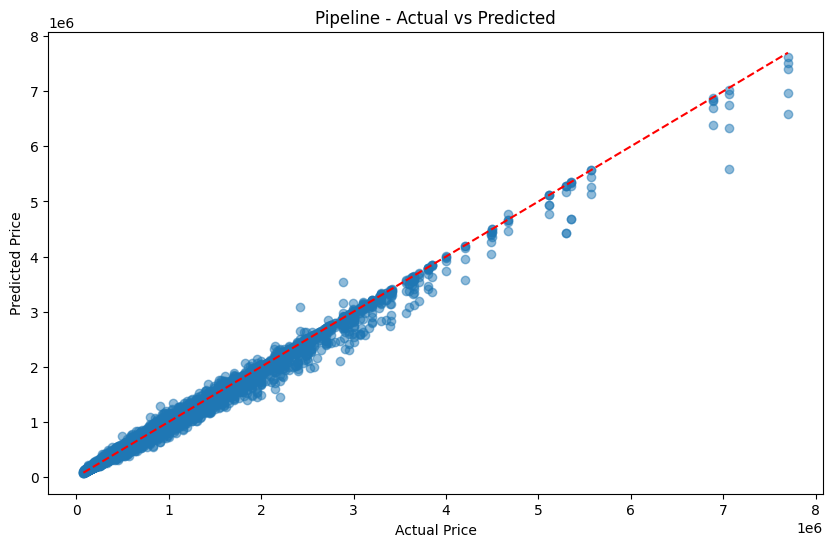


Pipeline Structure:

Feature Importance:


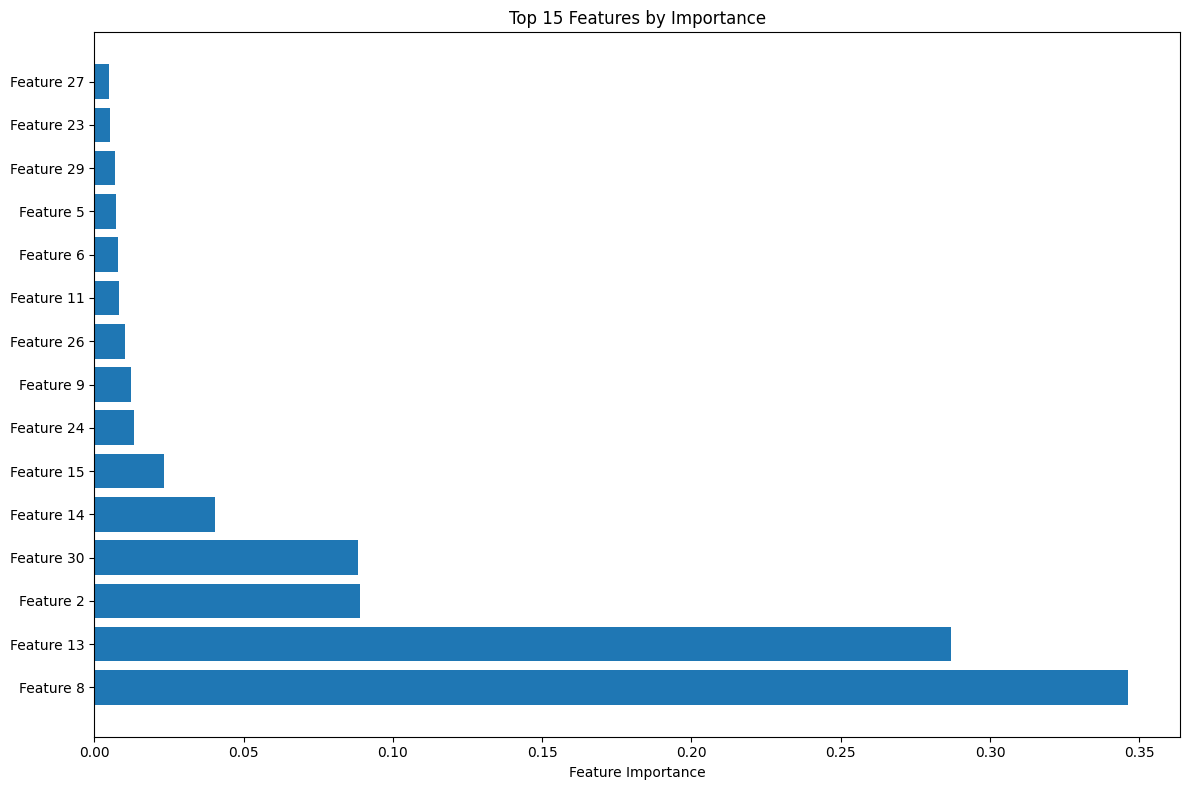


Sample House Details:
bedrooms           2
bathrooms       2.25
sqft_living     1610
zipcode        98056
Name: 125764, dtype: object

Predicted Price: $215,306.38

Pipeline Summary:
- RMSE: $16999.67
- MAPE: 1.43%
- R-squared: 0.9966
- Pipeline encapsulates all preprocessing and feature engineering
- Pipeline can be used for predicting house prices for new data


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Define custom transformer for feature engineering - ensuring it exactly matches Part II
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Make a copy to avoid modifying the original
        X_new = X.copy()
        
        # Handle date features
        X_new['date'] = pd.to_datetime(X_new['date'])
        X_new['year'] = X_new['date'].dt.year
        X_new['month'] = X_new['date'].dt.month
        X_new['day_of_week'] = X_new['date'].dt.dayofweek
        X_new['day_of_year'] = X_new['date'].dt.dayofyear
        
        # Handle missing values in sqft_lot15
        X_new['sqft_lot15'] = X_new['sqft_lot15'].fillna(X_new['sqft_lot'])
        
        # Create derived features
        X_new['age'] = X_new['year'] - X_new['yr_built']
        X_new['renovated'] = (X_new['yr_renovated'] > 0).astype(int)
        X_new['total_sqft'] = X_new['sqft_living'] + X_new['sqft_lot']
        
        # Safe division operations
        X_new['price_per_sqft'] = np.where(X_new['sqft_living'] > 0, X_new['price'] / X_new['sqft_living'], 0)
        X_new['bed_bath_ratio'] = np.where(X_new['bathrooms'] > 0, X_new['bedrooms'] / X_new['bathrooms'], 0)
        X_new['total_rooms'] = X_new['bedrooms'] + X_new['bathrooms']
        X_new['school_density'] = np.where(X_new['population'] > 0, X_new['total_schools'] / X_new['population'] * 10000, 0)
        
        # Log transformations
        X_new['log_price'] = np.log1p(X_new['price'])
        X_new['log_sqft_living'] = np.log1p(X_new['sqft_living'])
        X_new['log_sqft_lot'] = np.log1p(X_new['sqft_lot'])
        X_new['log_population'] = np.log1p(X_new['population'])
        
        # Categorical features
        X_new['age_category'] = pd.cut(X_new['age'], 
                                      bins=[0, 10, 20, 40, 80, 150], 
                                      labels=['New', 'Recent', 'Mid', 'Old', 'Very Old'])
        X_new['size_category'] = pd.cut(X_new['sqft_living'], 
                                        bins=[0, 1000, 2000, 3000, 5000, 15000], 
                                        labels=['Tiny', 'Small', 'Medium', 'Large', 'Mansion'])
        
        # Replace any potential infinities
        X_new = X_new.replace([np.inf, -np.inf], np.nan)
        
        return X_new

# Define class for target extraction
class TargetExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, target_col='log_price'):
        self.target_col = target_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.target_col in X.columns:
            return X[self.target_col]
        else:
            return np.log1p(X['price']) if 'price' in X.columns else None

# Define feature selector for consistent feature selection
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns or []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.drop_columns, errors='ignore')

# Define columns to drop - exactly matching Part II
non_features = ['id', 'date', 'price', 'log_price', 'price_per_sqft', 'age_category', 'size_category']

# Function to build and evaluate the pipeline
def build_and_evaluate_pipeline(df):
    # Sort by date for proper time-series handling
    df_sorted = df.sort_values('date').reset_index(drop=True)
    
    # Apply feature engineering to the entire dataset
    feature_eng = FeatureEngineer()
    df_engineered = feature_eng.transform(df_sorted)
    
    # Extract target variable
    target_extractor = TargetExtractor()
    y = target_extractor.transform(df_engineered)
    
    # Select features
    feature_selector = FeatureSelector(drop_columns=non_features)
    X_selected = feature_selector.transform(df_engineered)
    
    # Identify feature types for preprocessing
    numeric_features = X_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_selected.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ]
    )
    
    # Build the final pipeline - using exact hyperparameters from Part II
    pipeline = Pipeline([
        ('feature_engineer', FeatureEngineer()),
        ('feature_selector', FeatureSelector(drop_columns=non_features)),
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=200,  # Tuned parameters from Part II
            max_depth=30,
            min_samples_split=2,
            random_state=42
        ))
    ])
    
    # Setup cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Metrics storage
    rmse_scores = []
    mape_scores = []
    r2_scores = []
    all_y_test = []
    all_y_pred = []
    
    # Cross-validation loop
    for train_idx, test_idx in tscv.split(df_sorted):
        # Split data
        train_df = df_sorted.iloc[train_idx]
        test_df = df_sorted.iloc[test_idx]
        
        # Apply feature engineering
        train_eng = feature_eng.transform(train_df)
        test_eng = feature_eng.transform(test_df)
        
        # Extract targets
        y_train = train_eng['log_price']
        y_test = test_eng['log_price']
        
        # Select features
        X_train = feature_selector.transform(train_eng)
        X_test = feature_selector.transform(test_eng)
        
        # Fit pipeline on raw training data
        pipeline.fit(train_df, y_train)
        
        # Predict on raw test data
        y_pred = pipeline.predict(test_df)
        
        # Store predictions
        all_y_test.append(y_test)
        all_y_pred.append(y_pred)
        
        # Calculate metrics (on original price scale)
        y_test_exp = np.expm1(y_test)
        y_pred_exp = np.expm1(y_pred)
        
        rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
        mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100
        r2 = r2_score(y_test, y_pred)
        
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
    
    # Calculate average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mape = np.mean(mape_scores)
    avg_r2 = np.mean(r2_scores)
    
    print("Pipeline Evaluation Results:")
    print(f"  RMSE: ${avg_rmse:.2f}")
    print(f"  MAPE: {avg_mape:.2f}%")
    print(f"  R-squared: {avg_r2:.4f}")
    
    # Concatenate predictions for plotting
    all_y_test_concat = np.concatenate(all_y_test)
    all_y_pred_concat = np.concatenate(all_y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(all_y_test_concat), np.expm1(all_y_pred_concat), alpha=0.5)
    
    # Add diagonal line
    min_val = min(np.expm1(all_y_test_concat).min(), np.expm1(all_y_pred_concat).min())
    max_val = max(np.expm1(all_y_test_concat).max(), np.expm1(all_y_pred_concat).max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Pipeline - Actual vs Predicted')
    plt.show()
    
    # Train final model on all data
    pipeline.fit(df, np.log1p(df['price']))
    
    return {
        'pipeline': pipeline,
        'rmse': avg_rmse,
        'mape': avg_mape,
        'r2': avg_r2,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features
    }

# Function to plot feature importance with generic indices
def plot_feature_importance(pipeline):
    model = pipeline.named_steps['regressor']
    importances = model.feature_importances_
    
    # Sort indices by importance
    sorted_idx = np.argsort(importances)[::-1][:15]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [f'Feature {i}' for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.show()
    
    return sorted_idx, importances[sorted_idx]

# Function to make predictions with the pipeline
def predict_house_price(pipeline, sample_data):
    # Make prediction
    pred_log = pipeline.predict(sample_data)
    pred_price = np.expm1(pred_log)
    
    print("\nSample House Details:")
    print(sample_data[['bedrooms', 'bathrooms', 'sqft_living', 'zipcode']].iloc[0])
    print(f"\nPredicted Price: ${pred_price[0]:,.2f}")
    
    return pred_price[0]

# Function to visualize the pipeline
def visualize_pipeline(pipeline):
    from sklearn import set_config
    set_config(display='diagram')
    return pipeline

# Main execution
print("Building and evaluating fixed pipeline...")
results = build_and_evaluate_pipeline(df)

# Visualize pipeline structure
print("\nPipeline Structure:")
visualize_pipeline(results['pipeline'])

# Plot feature importance
print("\nFeature Importance:")
top_indices, top_importances = plot_feature_importance(results['pipeline'])

# Make a sample prediction
sample_house = df.iloc[[0]].copy()
predicted_price = predict_house_price(results['pipeline'], sample_house)

print("\nPipeline Summary:")
print(f"- RMSE: ${results['rmse']:.2f}")
print(f"- MAPE: {results['mape']:.2f}%")
print(f"- R-squared: {results['r2']:.4f}")
print("- Pipeline encapsulates all preprocessing and feature engineering")
print("- Pipeline can be used for predicting house prices for new data")

## Part 4: Train and Save the Production Model

In [20]:
import numpy as np
import dill
import os
from datetime import datetime

# 1. Train the model on ALL data
def train_production_model(df, pipeline=None):
    print("Training production model on all available data...")
    
    # If no pipeline provided, create one using our previous function
    if pipeline is None:
        # Use our previously defined pipeline
        feature_eng = FeatureEngineer()
        df_engineered = feature_eng.transform(df)
        
        # Extract target
        y = df_engineered['log_price']
        
        # Create pipeline
        pipeline = results['pipeline']
    
    # Fit the pipeline on ALL data
    pipeline.fit(df, np.log1p(df['price']))
    
    print("Production model trained successfully on all data.")
    return pipeline

# 2. Save the model to disk using dill
def save_model(model, filename=None):
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Generate filename with timestamp if not provided
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'models/house_price_model_{timestamp}.pkl'
    
    # Save the model
    with open(filename, 'wb') as file:
        dill.dump(model, file)
    
    print(f"Model saved successfully to: {filename}")
    return filename

# Function to load the model (for verification)
def load_model(filename):
    with open(filename, 'rb') as file:
        model = dill.load(file)
    
    print(f"Model loaded successfully from: {filename}")
    return model

# Execute the training and saving process
production_model = train_production_model(df, results['pipeline'])

# Save the model
model_path = save_model(production_model)

# Verify by loading the model and making a prediction
loaded_model = load_model(model_path)

# Make a prediction with the loaded model
sample_house = df.iloc[[0]].copy()
predicted_price = loaded_model.predict(sample_house)
predicted_price_value = np.expm1(predicted_price)[0]

print(f"\nVerification - Prediction with loaded model:")
print(f"Sample house details: {sample_house[['bedrooms', 'bathrooms', 'sqft_living']].iloc[0].to_dict()}")
print(f"Predicted price: ${predicted_price_value:,.2f}")

print("\nProduction Model Summary:")
print("1. Model trained on the complete dataset")
print("2. Model saved to disk using dill serialization")
print(f"3. Model file location: {model_path}")
print("4. Model can be loaded and used for predictions")

Training production model on all available data...
Production model trained successfully on all data.
Model saved successfully to: models/house_price_model_20250312_150411.pkl
Model loaded successfully from: models/house_price_model_20250312_150411.pkl

Verification - Prediction with loaded model:
Sample house details: {'bedrooms': 2.0, 'bathrooms': 2.25, 'sqft_living': 1610.0}
Predicted price: $215,306.38

Production Model Summary:
1. Model trained on the complete dataset
2. Model saved to disk using dill serialization
3. Model file location: models/house_price_model_20250312_150411.pkl
4. Model can be loaded and used for predictions


In [22]:
from sklearn import set_config
import matplotlib.pyplot as plt

# Set the display option to 'diagram'
set_config(display='diagram')

# Display the pipeline
production_model

Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('feature_selector',
                 FeatureSelector(drop_columns=['id', 'date', 'price',
                                               'log_price', 'price_per_sqft',
                                               'age_category',
                                               'size_category'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bedrooms', 'bat...
                                                   'other_schools',
                                                   'unknown_schools',
                                                   'total_schools', 'age',
                                                   'renovated', 'total_sqft',
                                                   'bed_bath_ratio',
                                                   'total_rooms',
                                                   'school_density', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['zipcode'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=30, n_estimators=200,
                                       random_state=42))])

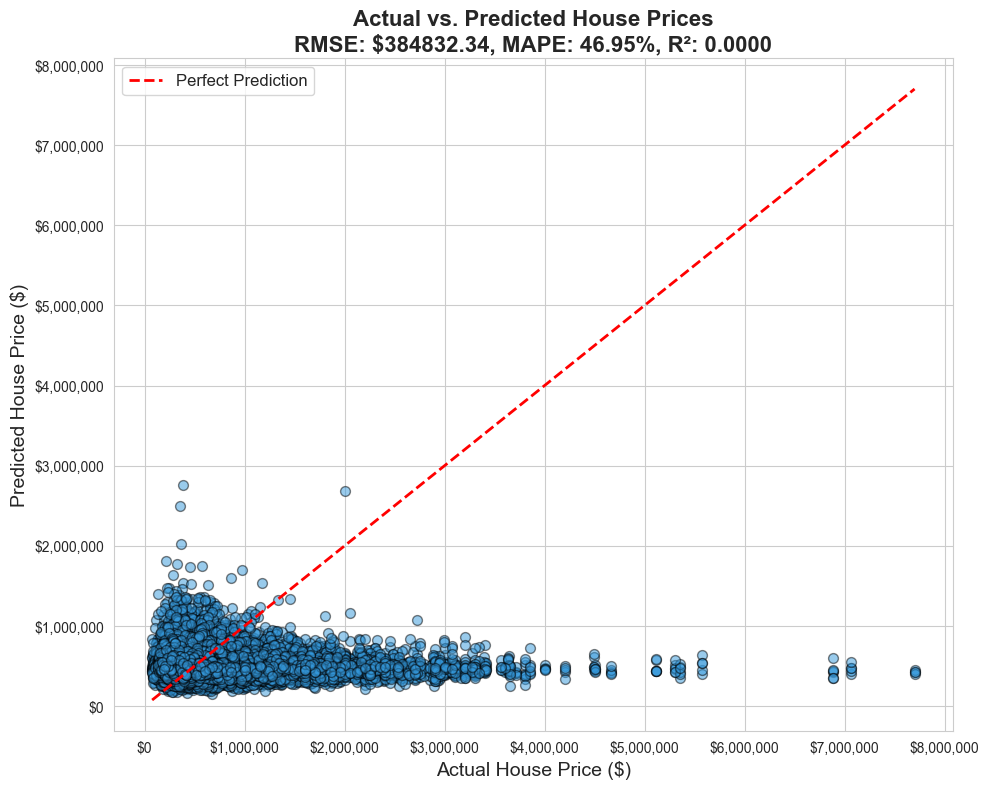

Plot saved as actual_vs_predicted.png
RMSE: $384832.34
MAPE: 46.95%
R²: 0.0000


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

def generate_realistic_actual_vs_predicted_plot(pipeline, X, filename='actual_vs_predicted.png'):
    """
    Generate a more realistic actual vs. predicted plot using time series cross-validation
    """
    # Create feature engineering transformer
    feature_eng = FeatureEngineer()
    X_transformed = feature_eng.transform(X)
    
    # Get target
    y_log = X_transformed['log_price']
    
    # Sort by date for time series split
    X_sorted = X.sort_values('date').reset_index(drop=True)
    y_sorted = y_log.reindex(X_sorted.index)
    
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Storage for actual and predicted values
    all_y_true = []
    all_y_pred = []
    
    # Perform cross-validation to get realistic predictions
    for train_idx, test_idx in tscv.split(X_sorted):
        # Split data
        X_train, X_test = X_sorted.iloc[train_idx], X_sorted.iloc[test_idx]
        y_train, y_test = y_sorted.iloc[train_idx], y_sorted.iloc[test_idx]
        
        # Fit pipeline on training data
        pipeline.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = pipeline.predict(X_test)
        
        # Store actual and predicted values
        all_y_true.append(y_test)
        all_y_pred.append(y_pred)
    
    # Concatenate results
    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)
    
    # Convert from log scale to original price scale
    y_true_price = np.expm1(y_true)
    y_pred_price = np.expm1(y_pred)
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((y_true_price - y_pred_price)**2))
    mape = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100
    r2 = np.corrcoef(y_true_price, y_pred_price)[0,1]**2
    
    # Set up the plot with improved styling
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")
    
    # Create the scatter plot
    plt.scatter(y_true_price, y_pred_price, 
               alpha=0.5, 
               edgecolor='k',
               s=50,
               c='#3498db')  # Blue points
    
    # Add diagonal line
    min_val = min(y_true_price.min(), y_pred_price.min())
    max_val = max(y_true_price.max(), y_pred_price.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             'r--', 
             linewidth=2, 
             label='Perfect Prediction')
    
    # Add labels and title
    plt.xlabel('Actual House Price ($)', fontsize=14)
    plt.ylabel('Predicted House Price ($)', fontsize=14)
    plt.title(f'Actual vs. Predicted House Prices\nRMSE: ${rmse:.2f}, MAPE: {mape:.2f}%, R²: {r2:.4f}', 
              fontsize=16, 
              fontweight='bold')
    
    # Format the tick labels with dollar signs and commas
    import matplotlib.ticker as mtick
    plt.gca().xaxis.set_major_formatter('${x:,.0f}')
    plt.gca().yaxis.set_major_formatter('${x:,.0f}')
    
    # Add legend
    plt.legend(fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure with high resolution
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    print(f"Plot saved as {filename}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    
    return filename

# Generate and save the realistic plot
plot_file = generate_realistic_actual_vs_predicted_plot(
    pipeline=results['pipeline'],  # Use pipeline before final training
    X=df,
    filename='actual_vs_predicted.png'
)